## Employee Churn Prediction

Binary Classification Problem to Predict Employee Churn (Leave the job or Not)

In [56]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mutual_info_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

### 1: Data Preparation
Datasource: https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset/data

Column-info:
- *Education*: The educational qualifications of employees, including degree, institution, and field of study.
- *Joining Year*: The year each employee joined the company, indicating their length of service.
- *City*: The location or city where each employee is based or works.
- *Payment Tier*: Categorization of employees into different salary tiers.
- *Age*: The age of each employee, providing demographic insights.
- *Gender*: Gender identity of employees, promoting diversity analysis.
- *Ever Benched*: Indicates if an employee has ever been temporarily without assigned work.
- *Experience in Current Domain*: The number of years of experience employees have in their current field.
- *Leave or Not*: a target column

In [2]:
df = pd.read_csv("employee-data.csv")
df.head(3)

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0


In [3]:
cat_cols = df.dtypes[df.dtypes == "object"].index
for c in cat_cols:
    df[c] = df[c].str.lower().str.replace(" ", "_")

df.columns = df.columns.str.lower()
cols = {"joiningyear": "joining_year", 
        "paymenttier": "payment_tier",
        "everbenched": "ever_benched",
        "experienceincurrentdomain": "experience",
        "leaveornot": "churn"
}
df = df.rename(columns=cols)

payment_class = {
    1: "high",
    2: "medium",
    3: "low"
}
df.payment_tier = df.payment_tier.map(payment_class)

### 2: EDA

- Sample data
- Data shape
- Data types
- Missing values
- Value counts
- Numerical descriptions
- Churn rate

In [4]:
df.head(3)

,education,joining_year,city,payment_tier,age,gender,ever_benched,experience,churn
0,bachelors,2017,bangalore,low,34,male,no,0,0
1,bachelors,2013,pune,high,28,female,no,3,1
2,bachelors,2014,new_delhi,low,38,female,no,2,0


In [5]:
df.shape

(4653, 9)

In [6]:
df.dtypes

education       object
joining_year     int64
city            object
payment_tier    object
age              int64
gender          object
ever_benched    object
experience       int64
churn            int64
dtype: object

In [7]:
df.isnull().sum().to_frame("# Nulls").T

,education,joining_year,city,payment_tier,age,gender,ever_benched,experience,churn
# Nulls,0,0,0,0,0,0,0,0,0


In [8]:
for c in df.dtypes[df.dtypes == "object"].index:
    print(df[c].value_counts(), end="\n\n")

education
bachelors    3601
masters       873
phd           179
Name: count, dtype: int64

city
bangalore    2228
pune         1268
new_delhi    1157
Name: count, dtype: int64

payment_tier
low       3492
medium     918
high       243
Name: count, dtype: int64

gender
male      2778
female    1875
Name: count, dtype: int64

ever_benched
no     4175
yes     478
Name: count, dtype: int64



In [9]:
df.describe()

,joining_year,age,experience,churn
count,4653.000000,4653.000000,4653.000000,4653.000000
mean,2015.062970,29.393295,2.905652,0.343864
std,1.863377,4.826087,1.558240,0.475047
min,2012.000000,22.000000,0.000000,0.000000
25%,2013.000000,26.000000,2.000000,0.000000
50%,2015.000000,28.000000,3.000000,0.000000
75%,2017.000000,32.000000,4.000000,1.000000
max,2018.000000,41.000000,7.000000,1.000000


In [10]:
df.churn.mean()

np.float64(0.3438641736514077)

#### 2.1: EDA: Feature Engineering

In [11]:
df["job_tenure"] = 2018 - df["joining_year"]

numerical = ["age", "experience", "job_tenure"]
categorical = ["education", "city", "payment_tier", "gender", "ever_benched"]

In [12]:
df[categorical].nunique().to_frame("# Unique Counts").T

,education,city,payment_tier,gender,ever_benched
# Unique Counts,3,3,3,2,2


In [13]:
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
age,4653.0,29.393295,4.826087,22.0,26.0,28.0,32.0,41.0
experience,4653.0,2.905652,1.558240,0.0,2.0,3.0,4.0,7.0
job_tenure,4653.0,2.937030,1.863377,0.0,1.0,3.0,5.0,6.0


#### 2.2: EDA: Feature Importance

- Mutual information
- Correlation
- Class balance

In [14]:
mi = df[categorical].apply(lambda s: mutual_info_score(df.churn, s))
mi = mi.sort_values()
mi

ever_benched    0.002969
education       0.010592
city            0.021632
gender          0.024192
payment_tier    0.034851
dtype: float64

Text(0.5, 0, 'mi_scores')

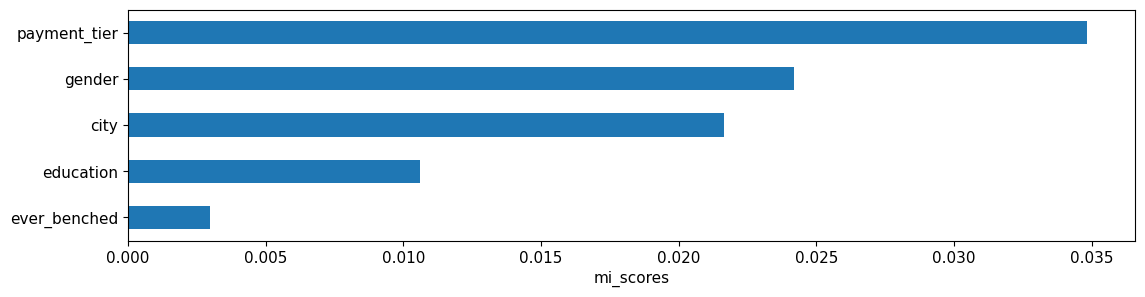

In [15]:
mi.plot.barh(figsize=(13,3), fontsize=11)
plt.xlabel("mi_scores", fontsize=11)

In [16]:
corr = df[numerical].corrwith(df.churn).sort_values(ascending=False)
corr

experience   -0.030504
age          -0.051126
job_tenure   -0.181705
dtype: float64

Text(0.5, 0, 'correlation')

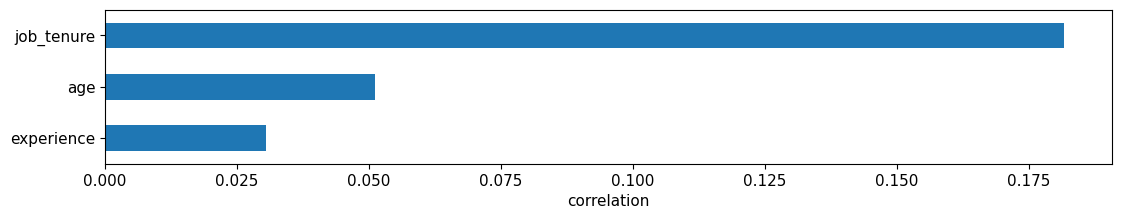

In [17]:
corr.abs().plot.barh(figsize=(13,2), fontsize=11)
plt.xlabel("correlation", fontsize=11)

In [18]:
counts = df.churn.value_counts(normalize=True).to_frame()
counts.T

churn,0,1
proportion,0.656136,0.343864


### 3: Validation Framework

In [19]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train["churn"]
del df_val["churn"]
del df_test["churn"]

In [20]:
len(df_train), len(df_val), len(df_test)

(2791, 931, 931)

### 4: Model Training

#### 4.1: Logistic Regression

In [21]:
def train_lr(df_train, y_train, C=1.0):
    dv = DictVectorizer(sparse=True)
    dict_train = df_train[numerical + categorical].to_dict(orient="records")
    X_train = dv.fit_transform(dict_train)

    model = LogisticRegression(max_iter=1000, C=C)
    model.fit(X_train, y_train)
    return dv, model

In [22]:
def predict_lr(df_val, dv, model):
    dict_val = df_val[numerical + categorical].to_dict(orient="records")
    X_val = dv.transform(dict_val)

    y_pred = model.predict_proba(X_val)[:, 1]
    return y_pred

In [23]:
def get_scores(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred > 0.5)
    precision = precision_score(y_true, y_pred > 0.5)
    recall = recall_score(y_true, y_pred > 0.5)
    auc = roc_auc_score(y_true, y_pred)

    return (accuracy, precision, recall, auc)

In [24]:
dv, lr = train_lr(df_train, y_train)
y_pred = predict_lr(df_val, dv, lr)
get_scores(y_val, y_pred)

(0.7551020408163265,
 0.7071823204419889,
 0.42244224422442245,
 0.7413261230581658)

##### Tuning 'C' parameter

In [25]:
scores = []

for C in [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]:
    dv, model = train_lr(df_train, y_train, C=C)
    y_pred = predict_lr(df_val, dv, model)
    scores.append((C,) + get_scores(y_val, y_pred))

df_scores = pd.DataFrame(scores, columns=["C", "accuracy", "precision", "recall", "auc"])
df_scores

,C,accuracy,precision,recall,auc
0,0.001,0.682062,0.818182,0.029703,0.712926
1,0.010,0.721805,0.659420,0.300330,0.743533
2,0.100,0.748657,0.697143,0.402640,0.742556
3,0.500,0.755102,0.707182,0.422442,0.741599
4,1.000,0.755102,0.707182,0.422442,0.741326
5,5.000,0.752954,0.699454,0.422442,0.741232
6,10.000,0.754028,0.703297,0.422442,0.741321


##### Final LR Model

In [26]:
dv, lr = train_lr(df_train, y_train, C=1.0)

#### 4.2: Decision Tree

In [27]:
def train_dt(df_train, y_train, depth=None, leaf=1):
    dv = DictVectorizer(sparse=True)
    dict_train = df_train[numerical + categorical].to_dict(orient="records")
    X_train = dv.fit_transform(dict_train)

    model = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf)
    model.fit(X_train, y_train)

    return dv, model

In [28]:
def predict_dt(df_val, dv, model):
    dict_val = df_val[numerical + categorical].to_dict(orient="records")
    X_val = dv.transform(dict_val)

    y_pred = model.predict_proba(X_val)[:, 1]
    return y_pred

In [29]:
dv, dt = train_dt(df_train, y_train)
y_pred = predict_dt(df_val, dv, dt)
get_scores(y_val, y_pred)

(0.8238453276047261,
 0.7622641509433963,
 0.6666666666666666,
 0.8181428811670977)

##### Tuning depth & max_samples_leaf

In [30]:
scores = []
for d in [1, 2, 3, 4, 5, 10, 15, 20, None]:
    dv, dt = train_dt(df_train, y_train, depth=d)
    y_pred = predict_dt(df_val, dv, dt)
    scores.append((d,) + get_scores(y_val, y_pred))

df_scores = pd.DataFrame(scores, columns=["max_depth", "accuracy", "precision", "recall", "auc"])
df_scores

,max_depth,accuracy,precision,recall,auc
0,1.0,0.751880,0.986486,0.240924,0.619666
1,2.0,0.756176,0.629252,0.610561,0.741250
2,3.0,0.791622,0.779487,0.501650,0.787373
3,4.0,0.815252,0.835897,0.537954,0.816900
4,5.0,0.846402,0.830579,0.663366,0.850857
5,10.0,0.856069,0.859574,0.666667,0.856903
6,15.0,0.835661,0.795276,0.666667,0.831749
7,20.0,0.825994,0.766038,0.669967,0.818243
8,NaN,0.821697,0.754647,0.669967,0.814814


In [31]:
scores = []
for l in [1, 5, 10, 15, 20, 50, 100, 200]:
    dv, dt = train_dt(df_train, y_train, depth=10, leaf=l)
    y_pred = predict_dt(df_val, dv, dt)
    scores.append((l,) + get_scores(y_val, y_pred))

df_scores = pd.DataFrame(scores, columns=["min_samples_leaf", "accuracy", "precision", "recall", "auc"])
df_scores

,min_samples_leaf,accuracy,precision,recall,auc
0,1,0.856069,0.853556,0.673267,0.859313
1,5,0.862513,0.863071,0.686469,0.852565
2,10,0.860365,0.836576,0.709571,0.866494
3,15,0.851772,0.831325,0.683168,0.859957
4,20,0.851772,0.842324,0.669967,0.860188
5,50,0.838883,0.766551,0.726073,0.871736
6,100,0.815252,0.835897,0.537954,0.838660
7,200,0.790548,0.775510,0.501650,0.820939


##### Final DT Model

In [32]:
dv, dt = train_dt(df_train, y_train, depth=10, leaf=20)

#### 4.3: Random Forest

In [33]:
def train_rf(df_train, y_train, n=100, depth=None, leaf=1):
    dv = DictVectorizer(sparse=True)
    dict_train = df_train[numerical + categorical].to_dict(orient="records")
    X_train = dv.fit_transform(dict_train)

    model = RandomForestClassifier(n_estimators=n, 
                                   max_depth=depth,
                                   min_samples_leaf=leaf,
                                   random_state=1)
    model.fit(X_train, y_train)

    return dv, model

In [34]:
def predict_rf(df_val, dv, model):
    dict_val = df_val[numerical + categorical].to_dict(orient="records")
    X_val = dv.transform(dict_val)

    y_pred = model.predict_proba(X_val)[:, 1]
    return y_pred

In [35]:
dv, rf = train_rf(df_train, y_train)
y_pred = predict_rf(df_val, dv, rf)
get_scores(y_val, y_pred)

(0.8399570354457573,
 0.7961538461538461,
 0.6831683168316832,
 0.8744271720165646)

##### Tuning n_estimators, depth & max_samples_leaf

In [36]:
scores = []
for n in range(10, 201, 10):
    dv, rf = train_rf(df_train, y_train, n=n)
    y_pred = predict_rf(df_val, dv, rf)
    scores.append((n,) + get_scores(y_val, y_pred))

df_scores = pd.DataFrame(scores, columns=["n_estimators", "accuracy", "precision", "recall", "auc"])
df_scores

,n_estimators,accuracy,precision,recall,auc
0,10,0.835661,0.779851,0.689769,0.865554
1,20,0.834586,0.779026,0.686469,0.877155
2,30,0.835661,0.779851,0.689769,0.874593
3,40,0.836735,0.784906,0.686469,0.875307
4,50,0.839957,0.793893,0.686469,0.874735
5,60,0.838883,0.790875,0.686469,0.874919
6,70,0.843179,0.796226,0.696370,0.874729
7,80,0.839957,0.793893,0.686469,0.874593
8,90,0.841031,0.796935,0.686469,0.873854
9,100,0.839957,0.796154,0.683168,0.874427


In [37]:
scores = []
for d in [1, 2, 3, 4, 5, 10, 15, 20, None]:
    dv, rf = train_rf(df_train, y_train, n=150, depth=d)
    y_pred = predict_rf(df_val, dv, rf)
    scores.append((d,) + get_scores(y_val, y_pred))

df_scores = pd.DataFrame(scores, columns=["max_depth", "accuracy", "precision", "recall", "auc"])
df_scores

,max_depth,accuracy,precision,recall,auc
0,1.0,0.701396,0.962963,0.085809,0.790689
1,2.0,0.805585,0.891026,0.458746,0.818668
2,3.0,0.810956,0.899371,0.471947,0.848222
3,4.0,0.825994,0.937888,0.498350,0.861144
4,5.0,0.867884,0.963918,0.617162,0.873550
5,10.0,0.870032,0.882353,0.693069,0.888369
6,15.0,0.839957,0.805556,0.669967,0.880098
7,20.0,0.841031,0.803922,0.676568,0.875815
8,NaN,0.843179,0.803089,0.686469,0.874522


In [38]:
scores = []
for l in [1, 5, 10, 15, 20, 50, 100, 200]:
    dv, rf = train_rf(df_train, y_train, n=150, depth=10, leaf=l)
    y_pred = predict_rf(df_val, dv, rf)
    scores.append((l,) + get_scores(y_val, y_pred))

df_scores = pd.DataFrame(scores, columns=["min_samples_leaf", "accuracy", "precision", "recall", "auc"])
df_scores

,min_samples_leaf,accuracy,precision,recall,auc
0,1,0.870032,0.882353,0.693069,0.888369
1,5,0.864662,0.864198,0.693069,0.882326
2,10,0.854995,0.862069,0.660066,0.878505
3,15,0.851772,0.860262,0.650165,0.876062
4,20,0.847476,0.848485,0.646865,0.874966
5,50,0.836735,0.899471,0.561056,0.859902
6,100,0.808808,0.893082,0.468647,0.846550
7,200,0.712137,0.657658,0.240924,0.764276


##### Final RF Model

In [39]:
dv, rf = train_rf(df_train, y_train, n=150, depth=10, leaf=1)

#### 4.4: XGBoost

In [40]:
def train_xgb(df_train, y_train, n=10, eta=0.3, depth=6, leaf=1):
    dv = DictVectorizer(sparse=True)
    dict_train = df_train[numerical + categorical].to_dict(orient="records")
    X_train = dv.fit_transform(dict_train)

    model = XGBClassifier(
        objective='binary:logistic',
        n_estimators=n,
        learning_rate=eta,
        max_depth=depth,
        min_child_weight=leaf
    )
    model.fit(X_train, y_train)

    return dv, model

In [41]:
def predict_xgb(df_val, dv, model):
    dict_val = df_val[numerical + categorical].to_dict(orient="records")
    X_val = dv.transform(dict_val)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    return y_pred

In [42]:
dv, xgb = train_xgb(df_train, y_train)
y_pred = predict_xgb(df_val, dv, xgb)
get_scores(y_val, y_pred)

(0.8721804511278195, 0.896551724137931, 0.6864686468646864, 0.8850455109205189)

##### Tuning num_boost_round, eta, max_depth & min_child_weight

In [43]:
scores = []

for n in range(10, 201, 10):
    dv, xgb = train_xgb(df_train, y_train, n=n)
    y_pred = predict_xgb(df_val, dv, xgb)
    scores.append((n,) + get_scores(y_val, y_pred))

df_scores = pd.DataFrame(scores, columns=["n_boost_round", "accuracy", "precision", "recall", "auc"])
df_scores

,n_boost_round,accuracy,precision,recall,auc
0,10,0.872180,0.896552,0.686469,0.885046
1,20,0.872180,0.880165,0.702970,0.889452
2,30,0.868958,0.866397,0.706271,0.890172
3,40,0.864662,0.855422,0.702970,0.890046
4,50,0.862513,0.851406,0.699670,0.889352
5,60,0.857143,0.834646,0.699670,0.889342
6,70,0.859291,0.841270,0.699670,0.888412
7,80,0.859291,0.844000,0.696370,0.887634
8,90,0.857143,0.837302,0.696370,0.884586
9,100,0.859291,0.838583,0.702970,0.883908


In [44]:
scores = []

for eta in [0.01, 0.05, 0.1, 0.3, 0.5, 1.0]:
    dv, xgb = train_xgb(df_train, y_train, n=30, eta=eta)
    y_pred = predict_xgb(df_val, dv, xgb)
    scores.append((eta,) + get_scores(y_val, y_pred))

df_scores = pd.DataFrame(scores, columns=["eta", "accuracy", "precision", "recall", "auc"])
df_scores

,eta,accuracy,precision,recall,auc
0,0.01,0.801289,0.991667,0.392739,0.874288
1,0.05,0.873255,0.907489,0.679868,0.883445
2,0.10,0.875403,0.897872,0.696370,0.885739
3,0.30,0.868958,0.866397,0.706271,0.890172
4,0.50,0.856069,0.833992,0.696370,0.887986
5,1.00,0.843179,0.798479,0.693069,0.876944


In [45]:
scores = []

for d in [1, 2, 3, 4, 5, 10, 15, 20, None]:
    dv, xgb = train_xgb(df_train, y_train, n=30, eta=0.3, depth=d)
    y_pred = predict_xgb(df_val, dv, xgb)
    scores.append((d,) + get_scores(y_val, y_pred))

df_scores = pd.DataFrame(scores, columns=["max_depth", "accuracy", "precision", "recall", "auc"])
df_scores

,max_depth,accuracy,precision,recall,auc
0,1.0,0.800215,0.816216,0.498350,0.817696
1,2.0,0.830290,0.857143,0.574257,0.852957
2,3.0,0.851772,0.845188,0.666667,0.877023
3,4.0,0.864662,0.867220,0.689769,0.885203
4,5.0,0.865736,0.853175,0.709571,0.884741
5,10.0,0.856069,0.839357,0.689769,0.876450
6,15.0,0.851772,0.823529,0.693069,0.873345
7,20.0,0.850698,0.812977,0.702970,0.871080
8,NaN,0.868958,0.866397,0.706271,0.890172


In [46]:
scores = []

for l in [1, 5, 10, 15, 20, 50, 100, 200]:
    dv, xgb = train_xgb(df_train, y_train, n=30, eta=0.3, depth=5, leaf=l)
    y_pred = predict_xgb(df_val, dv, xgb)
    scores.append((l,) + get_scores(y_val, y_pred))

df_scores = pd.DataFrame(scores, columns=["min_child_weight", "accuracy", "precision", "recall", "auc"])
df_scores

,min_child_weight,accuracy,precision,recall,auc
0,1,0.865736,0.853175,0.709571,0.884741
1,5,0.871106,0.882845,0.696370,0.883577
2,10,0.870032,0.869919,0.706271,0.883632
3,15,0.863588,0.849206,0.706271,0.881701
4,20,0.864662,0.864198,0.693069,0.883703
5,50,0.786251,0.750000,0.514851,0.824302
6,100,0.759398,0.715847,0.432343,0.775312
7,200,0.679914,0.515528,0.273927,0.656784


##### Final XGB Model

In [47]:
dv, xgb = train_xgb(df_train, y_train, n=30, eta=0.3, depth=5, leaf=5)

### 5: Model Selection

In [48]:
scores = []

# Logistic Regression
dv, lr = train_lr(df_train, y_train, C=1.0)
y_pred = predict_lr(df_val, dv, lr)
score = get_scores(y_val, y_pred)
scores.append(("Logistic Regresson",) + score)

# Decision Tree
dv, dt = train_dt(df_train, y_train, depth=10, leaf=20)
y_pred = predict_dt(df_val, dv, dt)
score = get_scores(y_val, y_pred)
scores.append(("Decision Tree",) + score)

# Random Forest
dv, rf = train_rf(df_train, y_train, n=150, depth=10, leaf=1)
y_pred = predict_rf(df_val, dv, rf)
score = get_scores(y_val, y_pred)
scores.append(("Random Forest",) + score)

# Gradient Boosting
dv, xgb = train_xgb(df_train, y_train, n=30, eta=0.3, depth=5, leaf=5)
y_pred = predict_xgb(df_val, dv, xgb)
score = get_scores(y_val, y_pred)
scores.append(("Gradient Boosting",) + score)

In [49]:
df_scores = pd.DataFrame(scores, columns=["model", "accuracy", "precision", "recall", "auc"])
df_scores

,model,accuracy,precision,recall,auc
0,Logistic Regresson,0.755102,0.707182,0.422442,0.741326
1,Decision Tree,0.851772,0.842324,0.669967,0.860188
2,Random Forest,0.870032,0.882353,0.693069,0.888369
3,Gradient Boosting,0.871106,0.882845,0.696370,0.883577


### 6: Cross Validation

In [50]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kf.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values

    dv, model = train_xgb(df_train, y_train)
    y_pred = predict_xgb(df_val, dv, model)

    score = get_scores(y_val, y_pred)
    scores.append(score)

df_scores = pd.DataFrame(scores, columns=["accuracy", "precision", "recall", "auc"])
df_scores

,accuracy,precision,recall,auc
0,0.865772,0.862637,0.676724,0.878806
1,0.876510,0.892683,0.723320,0.904214
2,0.858871,0.874346,0.673387,0.876370
3,0.840054,0.885542,0.595142,0.853453
4,0.842742,0.887255,0.658182,0.875042


### 7: Testing & Exporting the Final Model

In [51]:
y_full_train = df_full_train.churn.values

dv, model = train_xgb(df_full_train, y_full_train)
y_pred = predict_xgb(df_test, dv, model)

scores = [get_scores(y_test, y_pred)]
df_scores = pd.DataFrame(scores, columns=["accuracy", "precision", "recall", "auc"])
df_scores

,accuracy,precision,recall,auc
0,0.854995,0.906977,0.678261,0.866978


##### Exporting the final model

In [55]:
output_file = "model_v20251111.bin"

with open(output_file, "wb") as f_out:
    pickle.dump((dv, model), f_out)